# Import packages

In [1]:
import pandas as pd
import re, string, unicodedata  #modul regular expression

import nltk
from nltk import word_tokenize, sent_tokenize  #Paket ini membagi teks input menjadi kata-kata.,                                  
from nltk.corpus import stopwords

import gensim
#Create Bigram & Trigram Models 
from gensim.models import Phrases
#corpora and model
from gensim import corpora, models
from gensim.models.coherencemodel import CoherenceModel

import pyLDAvis.gensim_models;pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

C:\Users\joser\AppData\Roaming\Python\Python37\site-packages\sklearn\decomposition\_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


# Import Dataset

In [2]:
df = pd.read_csv('tax_court_analytics_data.csv', sep=',', header=0)
df.head()

,Nomor Putusan,Jenis Pajak,Tahun Pajak,DV_Menang,case_circumstances,government_statement,taxpayer_statement,court_statement,court_considerants,case_contents,case_main_contents
0,Put.072196.16.pdf,PPN dan PPnBM,2007,0,bahwa nilai sengketa dalam sengketa banding in...,bahwa terbanding melakukan koreksi atas transa...,bahwa bukti yang pemohon banding sampaikan jel...,menurut majelis : bahwa yang menjadi sengketa ...,bahwa dalam sengketa banding ini tidak terdapa...,bahwa nilai sengketa dalam sengketa banding in...,bahwa terbanding melakukan koreksi atas transa...
1,Put.086980.15.pdf,PPh Badan,2011,0,bahwa nilai sengketa terbukti dalam sengketa b...,a. koreksi atas biaya royalty sebesar rp. 52.0...,menurut pemohon banding koreksi atas pembayara...,menurut majelis : bahwa yang menjadi sengketa ...,bahwa dalam sengketa banding ini tidak terdapa...,bahwa nilai sengketa terbukti dalam sengketa b...,a. koreksi atas biaya royalty sebesar rp. 52.0...
2,Put.087101.15.pdf,PPh Badan,2012,0,bahwa nilai sengketa terbukti dalam sengketa b...,bahwa menurut terbanding koreksi harga pokok p...,bahwa metode comparable uncontrolled price (cu...,menurut majelis : bahwa majelis berpendapat sk...,bahwa dalam hal dilakukan analisa berdasar com...,bahwa nilai sengketa terbukti dalam sengketa b...,bahwa menurut terbanding koreksi harga pokok p...
3,Put.098444.15.pdf,PPh Badan,2012,1,bahwa nilai sengketa terbukti dalam banding in...,bahwa dasar dilakukan koreksi technical assist...,pemohon banding mengemukakan mengenai jasa yan...,menurut majelis : bahwa yang menjadi sengketa ...,"atas hasil pemeriksaan dalam persidangan, maje...",bahwa nilai sengketa terbukti dalam banding in...,bahwa dasar dilakukan koreksi technical assist...
4,Put.098538.15.pdf,PPh Badan,2012,0,bahwa nilai yang menjadi pokok sengketa dalam ...,bahwa oleh terbanding dalam sub dan penjelasan...,bahwa pemohon banding menambahkan penjelasanny...,menurut majelis : bahwa yang menjadi sengketa ...,bahwa atas hasil pemeriksaan dalam persidangan...,bahwa nilai yang menjadi pokok sengketa dalam ...,bahwa oleh terbanding dalam sub dan penjelasan...


In [3]:
df['case_contents'] = df['case_contents'].str.replace('royalty','royalti')
df['taxpayer_statement'] = df['taxpayer_statement'].str.replace('royalty','royalti')
df['government_statement'] = df['government_statement'].str.replace('royalty','royalti')
df['court_statement'] = df['court_statement'].str.replace('royalty','royalti')
df['case_main_contents'] = df['case_main_contents'].str.replace('royalty','royalti')

# Latent Dirichlet Allocation Steps

## 1. Preprocess

Preprocessing yang dilakukan adalah yang pertama dengan menghilangkan stopwords. Stopwords diperoleh dari library nltk bahasa Indonesia, dan dapat dikustomisasi sesuai kebutuhan. Stopwords yang dikustomisasi utamanya adalah kata-kata yang hampir selalu ada di semua putusan sehingga keberadaannya tidak memberikan nilai tambah terhadap hasil analisis.

Setelah itu dilakukan pembersihan dengan menghilangkan karakter non ASCII, URLs, punctuations, digit angka, serta additional white space. Pembersihan digunakan dengan bantuan library regular expression.

## 2. Creating Bigram & Trigram Models

Bigrams adalah dua kata yang sering muncul bersama dalam dokumen. Trigram adalah 3 kata yang sering muncul.

Package yang digunakan adalah gensim, di antaranya modul gensim.model dan gensim.corpora. Modul gensim.model digunakan untuk membangun model LDA dengan memanggil modul LdaModel. Selain itu juga akan dipanggil ketika melakukan proses penghitungan coherence model yang dilakukan dengan mengimpor modul CoherenceModel. Sedangkan modul gensim.corpora akan digunakan untuk membangun dictionary dari data teks sebelum dilakukan proses pembuatan model LDA. Pembuatan dictionary dilakukan dengan memanggil modul Dictionary.

## 3. Create the corpus

Dua input utama untuk Topic Modeling LDA adalah dictionary dan corpus.

Langkah pertama membuat kamus (dictionary) dari list text yang berisi berapa kali sebuah kata muncul di training set menggunakan corpora.Dictionary().

Nantinya, kita bisa memfilter kata apa saja yang akan dimasukkan dalam dictionary, dengan menggunakan dictionary.filter_extremes() yang menerima argumen yaitu 'no_below' dan 'no_above'. no_below (int, optional) – menentukan hanya mengambil kata-kata (tokens) yang termuat dalam paling sedikit no_below dokumen. Jadi jika no_below di-setting 5, maka kata atau token yang masuk ke dictionary adalah token yang termuat di minimal 5 dokumen. no_above (float, optional) – menentukan hanya mengambil kata-kata (tokens) yang termuat di maksimal sebanyak no_above dokumen, yakni fraksi atau bagian dari total ukuran korpus. Jadi jika no-above di-setting 0.2 maka token yang dimunculkan hanya token yang muncul pada sebanyak 0.2 dari keseluruhan jumlah dokumen. Ada juga keep_n untuk membatasi berapa most jumlah frequent tokens yang akan diambil.

Selanjutnya, Gensim membuat id unik untuk setiap kata dalam dokumen. Korpus yang dihasilkan adalah pemetaan dari (word_id, word_frequency). Untuk melakukannya digunakan doc2bow dari gensim. Untuk masing-masing dokumen, doc2bow akan membuat sebuah dictionary yang berisi berapa jumlah kata yang ada dan berpa kali kata tersebut muncul dalam dokumen. Misalnya jika corpus berisi (6, 1), artinya kata atau token dengan id 6 muncul sekali dalam dokumen pertama. Demikian juga, jika corpus berisi (18,6) maka kata dengan id 18 muncul enam kali.

## 4. Create TF-IDF model

TF-IDF (term frequency-inverse document frequency) is a statistical measure that evaluates how relevant a word is to a document in a collection of documents. This is done by multiplying two metrics: how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.

Create tf-idf model object using models.TfidfModel on ‘bow_corpus’ and save it to ‘tfidf’, then apply transformation to the entire corpus and call it ‘corpus_tfidf’. Finally we preview TF-IDF scores for our first document.

## 5. Menentukan banyaknya topik berdasarkan coherence score

Penentuan banyaknya model topik dilakukan dengan cara melihat visualisasi pada grafik coherence score. Coherence score adalah ukuran yang digunakan untuk mengevaluasi Topic Modeling, model yang baik akan menghasilkan topik dengan skor koherensi topik yang tinggi.

Semakin besar coherence score, maka semakin baik pula hasil interpretasi topic modeling yang dihasilkan. Misalnya Coherence score tertinggi yang dihasilkan pada jumlah topik tersebut adalah sebesar 0.511081. Berdasarkan hasil terbaik pada nilai coherence score tersebut, jumlah topik yang yang memiliki coherence score tersebut, misalnya 4, nantinya dijadikan acuan dalam membuat model.

## 6. Building the Topic Model

Setelah memiliki semua yang diperlukan untuk melatih model LDA. Selain korpus dan kamus, Kita perlu memberikan jumlah topiknya juga. Jumlah topik dipilih dari yang memiliki coherence-score tertinggi. 

Bagaimana menginterpretasikan hasil topic modellingnya?

Misalnya topik 0 diwakili sebagai 0.141*"sanksi_administrasi" + 0.113*"perkara" + 0.113*"penyerahan_ekspor" + 0.079*"kecuali_besarnya" + 0.077*"tergantung_penyelesaian" + 0.062*"neto" + 0.056*"barang_jasa" + 0.020*"positif" + 0.018*"sanksi" + 0.018*"administrasi"

Ini berarti 10 kata kunci teratas yang berkontribusi pada topik ini adalah: ‘sanksi_administrasi’, ‘perkara’, ‘penyerahan_ekspor’, ‘kecuali_besarnya’ .. dan seterusnya dan bobot ‘sanksi_administrasi’ pada topik 0 adalah 0,141. Bobot mencerminkan betapa pentingnya kata kunci untuk topik itu.

## 7. Topic Modelling Visualization 

Setelah itu dilakukan visualisasi untuk mempermudah labeling dari masing-masing topik. library yang digunakan adalah pyLDAVis.

## 8. Menyimpan model
Model yang telah dibuat disimpan untuk digunakan ketika deployment

### Preprocess Functions

In [4]:
#preprocessing
#credit to: @listari.tari on Medium 
#https://medium.com/@listari.tari/topic-modelling-menggunakan-latent-dirchlect-allocation-part-1-pre-processing-data-dengan-python-87bf5c580923

def removeStopword(str):
    stop_words_indonesian = set(stopwords.words('indonesian_tax_court'))
    #stop_words_english = set(stopwords.words('english'))
    additional_stopwords = open("additional_stopwords.txt", "r").read().split("\n")
    word_tokens = word_tokenize(str)
    filtered_sentence_indonesian = [w for w in word_tokens if not w in stop_words_indonesian]
    #filtered_sentence_english = [w for w in filtered_sentence_indonesian if not w in stop_words_english]
    filtered_sentence = [w for w in filtered_sentence_indonesian if not w in additional_stopwords]
    return ' '.join(filtered_sentence)

def cleaning(str):
    #remove non-ascii
    str = unicodedata.normalize('NFKD', str).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    #remove URLs
    str = re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', str)
    #remove punctuations
    str = re.sub(r'[^\w]|_',' ',str)
    #remove digit from string
    str = re.sub("\S*\d\S*", "", str).strip()
    #remove digit or numbers
    str = re.sub(r"\b\d+\b", " ", str)
    #to lowercase
    str = str.lower()
    #Remove additional white spaces
    str = re.sub('[\s]+', ' ', str)
    return str

def preprocessing(str):
    str = cleaning(str)
    str = removeStopword(str)
    return str

### Coherence value function

In [5]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array
#function to compute coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start, step, coherence_method):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, iterations=100)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence=coherence_method)
        coherence_values.append(coherencemodel.get_coherence())
        
    return model_list, coherence_values

### Topic modelling function

In [6]:
def text_preprocess(text_df,column_name):
    
    #preprocess the content of the column
    #col = list(text_df.columns)
    #text_df[column_name] = text_df[column_name].apply(preprocessing)
    preprocessed_texts = text_df[column_name].apply(preprocessing)
    #text_list = [i.split() for i in text_df[column_name]]
    text_list = [i.split() for i in preprocessed_texts]
    
    # Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
    bigram = Phrases(text_list, min_count=10)
    trigram = Phrases(bigram[text_list])
    
    for idx in range(len(text_list)):
        for token in bigram[text_list[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                text_list[idx].append(token)
        for token in trigram[text_list[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                text_list[idx].append(token)
    return preprocessed_texts, text_list

def dictionary_generator(text_list, no_below, no_above):    
    # Create a dictionary representation of the documents.
    dictionary = corpora.Dictionary(text_list)
    dictionary.filter_extremes(no_below=no_below, no_above=no_above) 
    #no_below (int, optional) – Keep tokens which are contained in at least no_below documents.
    #no_above (float, optional) – Keep tokens which are contained in no more than no_above documents (fraction of total corpus size, not an absolute number).
    return dictionary

def corpus_build(text_list, dictionary):
    #https://radimrehurek.com/gensim/tut1.html 
    #build corpus
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_list]
    #The function doc2bow converts document (a list of words) into the bag-of-words format
    
    return doc_term_matrix

def topic_modelling(text_df,column_name,label,no_below,no_above, limit, coherence_method):
    
    preprocessed_texts, text_list = text_preprocess(text_df,column_name)
    dictionary = dictionary_generator(text_list, no_below, no_above)
    doc_term_matrix = corpus_build(text_list,dictionary)
    
    #tfidf = models.TfidfModel(doc_term_matrix) #build TF-IDF model
    #corpus_tfidf = tfidf[doc_term_matrix]
    
    start=2
    limit=limit
    step=1
    #model_list, coherence_values = compute_coherence_values(dictionary, corpus=corpus_tfidf, 
    model_list, coherence_values = compute_coherence_values(dictionary, corpus=doc_term_matrix,
                                                            texts=text_list, start=start, 
                                                            limit=limit, step=step, coherence_method=coherence_method)
    #show graphs
    import matplotlib.pyplot as plt
    x = range(start, limit, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    
    number_of_topics = 0
    coherence = 0
    # Print the coherence scores
    for m, cv in zip(x, coherence_values):
        print("Num Topics =", m, " has Coherence Value of", round(cv, 6))
        if coherence_method=='u_mass':
            if round(cv,6)<coherence:
                coherence = round(cv,6)
                number_of_topics = m
        else:
            if round(cv,6)>coherence:
                coherence = round(cv,6)
                number_of_topics = m
    
    #model = LdaModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=number_of_topics) #num topic menyesuaikan hasil dari coherence value paling tinggi
    model = LdaModel(corpus=doc_term_matrix, id2word=dictionary, num_topics=number_of_topics,
                    passes=40,iterations=200,  chunksize = 10000, eval_every = None, random_state=0)
    for idx, topic in model.print_topics(-1):
        print('Topic: {} Word: {}'.format(idx, topic))
    
    #data = pyLDAvis.gensim_models.prepare(model, corpus_tfidf, dictionary)
    data = pyLDAvis.gensim_models.prepare(model, doc_term_matrix, dictionary)
    print(data)
    pyLDAvis.save_html(data, 'lda-gensim-'+column_name+'-'+coherence_method+'-'+label+'.html')
    model.save(label+'_'+column_name+'-'+coherence_method+'_lda.model')
    return preprocessed_texts, text_list, doc_term_matrix, dictionary, model

In [24]:
df_pph_badan = df[df['Jenis Pajak']=='PPh Badan']
df_pph_badan['txpayer_statement'] = df_pph_badan['case_circumstances']+df_pph_badan['taxpayer_statement']

In [59]:
#preprocess pph badan text column
preprocessed_pph_government_text,dataset_pph_government_text_list = text_preprocess(text_df=df_pph_badan,column_name='government_statement')
df_pph_badan['government_statement_preprocessed'] = preprocessed_pph_government_text
preprocessed_pph_taxpayer_text,dataset_pph_taxpayer_text_list = text_preprocess(text_df=df_pph_badan,column_name='txpayer_statement')
df_pph_badan['taxpayer_statement_preprocessed'] = preprocessed_pph_taxpayer_text
preprocessed_pph_court_text,dataset_pph_court_text_list = text_preprocess(text_df=df_pph_badan,column_name='court_statement')
df_pph_badan['court_statement_preprocessed'] = preprocessed_pph_court_text
df_pph_badan.head()

,Nomor Putusan,Jenis Pajak,Tahun Pajak,DV_Menang,case_circumstances,government_statement,taxpayer_statement,court_statement,court_considerants,case_contents,case_main_contents,txpayer_statement,government_statement_preprocessed,taxpayer_statement_preprocessed,court_statement_preprocessed,government_statement_bow,taxpayer_statement_bow,court_statement_bow
1,Put.086980.15.pdf,PPh Badan,2011,0,bahwa nilai sengketa terbukti dalam sengketa b...,a. koreksi atas biaya royalti sebesar rp. 52.0...,menurut pemohon banding koreksi atas pembayara...,menurut majelis : bahwa yang menjadi sengketa ...,bahwa dalam sengketa banding ini tidak terdapa...,bahwa nilai sengketa terbukti dalam sengketa b...,a. koreksi atas biaya royalti sebesar rp. 52.0...,bahwa nilai sengketa terbukti dalam sengketa b...,biaya royalti argumentasi keberatannya beralas...,neto disetujui biaya royalty biaya brand fee p...,neto disetujui biaya royalti biaya brand fee b...,"[(0, 1), (1, 1), (2, 3), (3, 1), (4, 1), (5, 1...","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...","[(0, 1), (1, 1), (2, 1), (3, 4), (4, 1), (5, 1..."
2,Put.087101.15.pdf,PPh Badan,2012,0,bahwa nilai sengketa terbukti dalam sengketa b...,bahwa menurut terbanding koreksi harga pokok p...,bahwa metode comparable uncontrolled price (cu...,menurut majelis : bahwa majelis berpendapat sk...,bahwa dalam hal dilakukan analisa berdasar com...,bahwa nilai sengketa terbukti dalam sengketa b...,bahwa menurut terbanding koreksi harga pokok p...,bahwa nilai sengketa terbukti dalam sengketa b...,harga penjualan,neto us disetujui comparable uncontrolled pric...,skpkb nama tested party diuji,"[(8, 1), (9, 1)]","[(7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12...","[(75, 1), (129, 1), (130, 1), (131, 1), (132, 3)]"
3,Put.098444.15.pdf,PPh Badan,2012,1,bahwa nilai sengketa terbukti dalam banding in...,bahwa dasar dilakukan koreksi technical assist...,pemohon banding mengemukakan mengenai jasa yan...,menurut majelis : bahwa yang menjadi sengketa ...,"atas hasil pemeriksaan dalam persidangan, maje...",bahwa nilai sengketa terbukti dalam banding in...,bahwa dasar dilakukan koreksi technical assist...,bahwa nilai sengketa terbukti dalam banding in...,technical assistance fee memadai eksistansi ma...,netto perincian harga penjualan disetujui meng...,netto harga penjualan perincian harga penjuala...,"[(4, 1), (10, 1), (11, 1)]","[(14, 3), (15, 1), (16, 1), (17, 1), (18, 3), ...","[(0, 1), (1, 1), (2, 6), (13, 3), (14, 6), (20..."
4,Put.098538.15.pdf,PPh Badan,2012,0,bahwa nilai yang menjadi pokok sengketa dalam ...,bahwa oleh terbanding dalam sub dan penjelasan...,bahwa pemohon banding menambahkan penjelasanny...,menurut majelis : bahwa yang menjadi sengketa ...,bahwa atas hasil pemeriksaan dalam persidangan...,bahwa nilai yang menjadi pokok sengketa dalam ...,bahwa oleh terbanding dalam sub dan penjelasan...,bahwa nilai yang menjadi pokok sengketa dalam ...,sub iainnya jalannya pembebanan royalti dibeba...,netto biaya royalti disetujui mencoba mencari ...,netto biaya royalti disetujui informasi lampir...,"[(7, 2), (12, 1), (13, 1), (14, 2), (15, 1), (...","[(5, 1), (66, 2), (67, 1), (68, 1), (69, 3), (...","[(9, 13), (10, 1), (11, 1), (14, 1), (26, 1), ..."
12,Put.106741.15.pdf,PPh Badan,2013,0,bahwa nilai sengketa terbukti dalam sengketa b...,bahwa pada saat pembahasan akhir hasil pemerik...,"bahwa koreksi positif sejumlah usd12,914,809 m...","menurut majelis : bahwa menurut terbanding, te...",bahwa dalam sengketa banding ini terdapat seng...,bahwa nilai sengketa terbukti dalam sengketa b...,bahwa pada saat pembahasan akhir hasil pemerik...,bahwa nilai sengketa terbukti dalam sengketa b...,pembahasan rincian penggunaan pinjaman bank pe...,neto biaya bunga pinjaman disetujui biaya bung...,biaya bunga pinjaman dikurangkan bruto neto ne...,"[(2, 23), (6, 1), (12, 7), (13, 1), (14, 2), (...","[(0, 4), (3, 3), (5, 1), (26, 1), (48, 4), (53...","[(5, 1), (6, 2), (11, 5), (12, 27), (27, 2), (..."


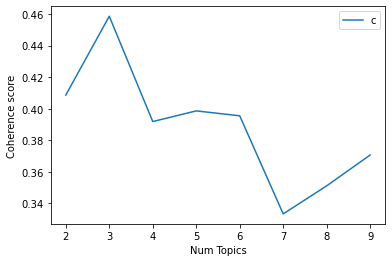

Num Topics = 2  has Coherence Value of 0.408609
Num Topics = 3  has Coherence Value of 0.45852
Num Topics = 4  has Coherence Value of 0.391864
Num Topics = 5  has Coherence Value of 0.398607
Num Topics = 6  has Coherence Value of 0.395506
Num Topics = 7  has Coherence Value of 0.333396
Num Topics = 8  has Coherence Value of 0.351175
Num Topics = 9  has Coherence Value of 0.370686
Topic: 0 Word: 0.181*"penjualan" + 0.120*"biaya" + 0.047*"harga" + 0.039*"manajemen" + 0.030*"sales" + 0.030*"pembayaran" + 0.028*"dibebankan" + 0.027*"manfaat" + 0.021*"tertulis" + 0.018*"kredit"
Topic: 1 Word: 0.181*"bunga" + 0.138*"biaya" + 0.045*"perjanjian" + 0.045*"kredit" + 0.040*"dibebankan" + 0.040*"pk" + 0.029*"piutang" + 0.024*"diperoleh" + 0.024*"mata" + 0.024*"uang"
Topic: 2 Word: 0.073*"operating" + 0.062*"margin" + 0.050*"pembanding" + 0.050*"documentation" + 0.050*"peredaran" + 0.038*"rentang" + 0.027*"fee" + 0.027*"tagihan" + 0.027*"invoice" + 0.027*"tnmm"
PreparedData(topic_coordinates=      

In [60]:
pph_government_preprocessed_texts, pph_government_text_list, pph_government_doc_term_matrix, pph_government_dictionary, pph_government_model= topic_modelling(text_df=df_pph_badan, column_name='government_statement', label='PPhBadan_government_statement_bow3',no_below=2,no_above=0.4, limit=10, coherence_method='c_v')

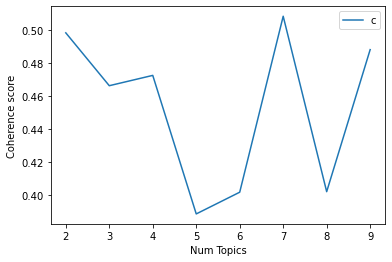

Num Topics = 2  has Coherence Value of 0.49838
Num Topics = 3  has Coherence Value of 0.466252
Num Topics = 4  has Coherence Value of 0.472521
Num Topics = 5  has Coherence Value of 0.388329
Num Topics = 6  has Coherence Value of 0.401528
Num Topics = 7  has Coherence Value of 0.508467
Num Topics = 8  has Coherence Value of 0.401844
Num Topics = 9  has Coherence Value of 0.488169
Topic: 0 Word: 0.024*"biaya" + 0.024*"know" + 0.016*"kuartil" + 0.016*"rentang" + 0.016*"aktiva" + 0.016*"rugi" + 0.016*"komponen" + 0.016*"penerapan" + 0.016*"penjualan" + 0.009*"fee"
Topic: 1 Word: 0.055*"bunga" + 0.052*"pif" + 0.035*"pinjaman" + 0.021*"saham" + 0.018*"bank" + 0.015*"biaya" + 0.015*"tagihan" + 0.012*"putusan" + 0.012*"perjanjian" + 0.012*"agreement"
Topic: 2 Word: 0.059*"komisi_penjualan" + 0.055*"penjualan" + 0.025*"biaya" + 0.023*"pofsb" + 0.023*"komisi" + 0.019*"harga" + 0.018*"grup" + 0.013*"pemasaran" + 0.012*"pembeli" + 0.011*"sales"
Topic: 3 Word: 0.054*"merek" + 0.024*"denda" + 0.024

In [64]:
pph_taxpayer_preprocessed_texts, pph_taxpayer_text_list, pph_taxpayer_doc_term_matrix, pph_taxpayer_dictionary, pph_taxpayer_model = topic_modelling(text_df=df_pph_badan, column_name='taxpayer_statement', label='PPhBadan_taxpayer_statement_bow3',no_below=1,no_above=0.9, limit=10, coherence_method='c_v')

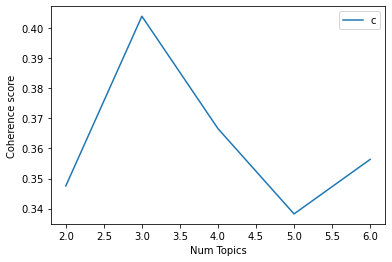

Num Topics = 2  has Coherence Value of 0.347531
Num Topics = 3  has Coherence Value of 0.403887
Num Topics = 4  has Coherence Value of 0.366563
Num Topics = 5  has Coherence Value of 0.338241
Num Topics = 6  has Coherence Value of 0.356341
Topic: 0 Word: 0.060*"royalti" + 0.045*"pembayaran_royalti" + 0.018*"merek_dagang" + 0.016*"manfaat_ekonomis" + 0.015*"biaya_royalti" + 0.009*"technical_assistance" + 0.009*"merek" + 0.008*"cup" + 0.008*"manfaat" + 0.008*"dagang"
Topic: 1 Word: 0.036*"operating_margin" + 0.016*"profit_indicator" + 0.016*"operasi" + 0.014*"analisa_kesebandingan" + 0.014*"profit" + 0.013*"transactional_margin" + 0.013*"tested_party" + 0.012*"technology" + 0.011*"analisa" + 0.010*"expenses"
Topic: 2 Word: 0.041*"biaya_bunga" + 0.025*"bunga" + 0.021*"know" + 0.018*"saham" + 0.015*"pinjaman" + 0.014*"tested_party" + 0.012*"pembelian" + 0.012*"modal" + 0.011*"cost_plus" + 0.011*"fee"
PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic

In [71]:
pph_court_preprocessed_texts, pph_court_text_list, pph_court_doc_term_matrix, pph_court_dictionary, pph_court_model = topic_modelling(text_df=df_pph_badan, column_name='court_statement', label='PPhBadan_court_statement_bow3',no_below=2,no_above=0.4, limit=7, coherence_method='c_v')

In [67]:
df_pph_badan['government_statement_bow'] = pph_government_doc_term_matrix
df_pph_badan['taxpayer_statement_bow'] = pph_taxpayer_doc_term_matrix
df_pph_badan['court_statement_bow'] = pph_court_doc_term_matrix
df_pph_badan.head(20)

,Nomor Putusan,Jenis Pajak,Tahun Pajak,DV_Menang,case_circumstances,government_statement,taxpayer_statement,court_statement,court_considerants,case_contents,case_main_contents,txpayer_statement,government_statement_preprocessed,taxpayer_statement_preprocessed,court_statement_preprocessed,government_statement_bow,taxpayer_statement_bow,court_statement_bow
1,Put.086980.15.pdf,PPh Badan,2011,0,bahwa nilai sengketa terbukti dalam sengketa b...,a. koreksi atas biaya royalti sebesar rp. 52.0...,menurut pemohon banding koreksi atas pembayara...,menurut majelis : bahwa yang menjadi sengketa ...,bahwa dalam sengketa banding ini tidak terdapa...,bahwa nilai sengketa terbukti dalam sengketa b...,a. koreksi atas biaya royalti sebesar rp. 52.0...,bahwa nilai sengketa terbukti dalam sengketa b...,biaya royalti argumentasi keberatannya beralas...,neto disetujui biaya royalty biaya brand fee p...,neto disetujui biaya royalti biaya brand fee b...,"[(0, 1), (1, 1), (2, 3), (3, 1), (4, 1), (5, 1...","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...","[(0, 1), (1, 1), (2, 1), (3, 4), (4, 1), (5, 1..."
2,Put.087101.15.pdf,PPh Badan,2012,0,bahwa nilai sengketa terbukti dalam sengketa b...,bahwa menurut terbanding koreksi harga pokok p...,bahwa metode comparable uncontrolled price (cu...,menurut majelis : bahwa majelis berpendapat sk...,bahwa dalam hal dilakukan analisa berdasar com...,bahwa nilai sengketa terbukti dalam sengketa b...,bahwa menurut terbanding koreksi harga pokok p...,bahwa nilai sengketa terbukti dalam sengketa b...,harga penjualan,neto us disetujui comparable uncontrolled pric...,skpkb nama tested party diuji,"[(8, 1), (9, 1)]","[(7, 1), (8, 1), (9, 1), (10, 1), (11, 2), (12...","[(75, 1), (129, 1), (130, 1), (131, 1), (132, 3)]"
3,Put.098444.15.pdf,PPh Badan,2012,1,bahwa nilai sengketa terbukti dalam banding in...,bahwa dasar dilakukan koreksi technical assist...,pemohon banding mengemukakan mengenai jasa yan...,menurut majelis : bahwa yang menjadi sengketa ...,"atas hasil pemeriksaan dalam persidangan, maje...",bahwa nilai sengketa terbukti dalam banding in...,bahwa dasar dilakukan koreksi technical assist...,bahwa nilai sengketa terbukti dalam banding in...,technical assistance fee memadai eksistansi ma...,netto perincian harga penjualan disetujui meng...,netto harga penjualan perincian harga penjuala...,"[(4, 1), (10, 1), (11, 1)]","[(14, 3), (15, 1), (16, 1), (17, 1), (18, 3), ...","[(0, 1), (1, 1), (2, 6), (13, 3), (14, 6), (20..."
4,Put.098538.15.pdf,PPh Badan,2012,0,bahwa nilai yang menjadi pokok sengketa dalam ...,bahwa oleh terbanding dalam sub dan penjelasan...,bahwa pemohon banding menambahkan penjelasanny...,menurut majelis : bahwa yang menjadi sengketa ...,bahwa atas hasil pemeriksaan dalam persidangan...,bahwa nilai yang menjadi pokok sengketa dalam ...,bahwa oleh terbanding dalam sub dan penjelasan...,bahwa nilai yang menjadi pokok sengketa dalam ...,sub iainnya jalannya pembebanan royalti dibeba...,netto biaya royalti disetujui mencoba mencari ...,netto biaya royalti disetujui informasi lampir...,"[(7, 2), (12, 1), (13, 1), (14, 2), (15, 1), (...","[(5, 1), (66, 2), (67, 1), (68, 1), (69, 3), (...","[(9, 13), (10, 1), (11, 1), (14, 1), (26, 1), ..."
12,Put.106741.15.pdf,PPh Badan,2013,0,bahwa nilai sengketa terbukti dalam sengketa b...,bahwa pada saat pembahasan akhir hasil pemerik...,"bahwa koreksi positif sejumlah usd12,914,809 m...","menurut majelis : bahwa menurut terbanding, te...",bahwa dalam sengketa banding ini terdapat seng...,bahwa nilai sengketa terbukti dalam sengketa b...,bahwa pada saat pembahasan akhir hasil pemerik...,bahwa nilai sengketa terbukti dalam sengketa b...,pembahasan rincian penggunaan pinjaman bank pe...,neto biaya bunga pinjaman disetujui biaya bung...,biaya bunga pinjaman dikurangkan bruto neto ne...,"[(2, 23), (6, 1), (12, 7), (13, 1), (14, 2), (...","[(0, 4), (3, 3), (5, 1), (26, 1), (48, 4), (53...","[(5, 1), (6, 2), (11, 5), (12, 27), (27, 2), (..."
15,Put.109167.15.pdf,PPh Badan,

In [72]:
df_ppn = df[df['Jenis Pajak']=='PPN dan PPnBM']
df_ppn['txpayer_statement'] = df_ppn['case_circumstances']+df_ppn['taxpayer_statement']

In [73]:
#preprocess pph badan text column
preprocessed_ppn_government_text,dataset_ppn_government_text_list = text_preprocess(text_df=df_ppn,column_name='government_statement')
df_ppn['government_statement_preprocessed'] = preprocessed_ppn_government_text
preprocessed_ppn_taxpayer_text,dataset_ppn_taxpayer_text_list = text_preprocess(text_df=df_ppn,column_name='txpayer_statement')
df_ppn['taxpayer_statement_preprocessed'] = preprocessed_ppn_taxpayer_text
preprocessed_ppn_court_text,dataset_ppn_court_text_list = text_preprocess(text_df=df_ppn,column_name='court_statement')
df_ppn['court_statement_preprocessed'] = preprocessed_ppn_court_text
df_ppn.head(66)

,Nomor Putusan,Jenis Pajak,Tahun Pajak,DV_Menang,case_circumstances,government_statement,taxpayer_statement,court_statement,court_considerants,case_contents,case_main_contents,txpayer_statement,government_statement_preprocessed,taxpayer_statement_preprocessed,court_statement_preprocessed
0,Put.072196.16.pdf,PPN dan PPnBM,2007,0,bahwa nilai sengketa dalam sengketa banding in...,bahwa terbanding melakukan koreksi atas transa...,bahwa bukti yang pemohon banding sampaikan jel...,menurut majelis : bahwa yang menjadi sengketa ...,bahwa dalam sengketa banding ini tidak terdapa...,bahwa nilai sengketa dalam sengketa banding in...,bahwa terbanding melakukan koreksi atas transa...,bahwa nilai sengketa dalam sengketa banding in...,nusantara inc nusantara inc informasi pasar gh...,barang pemanfaatan disetujui nusantara inc ent...,pemanfaatan disetujui penyerahan informasi pas...
5,Put.101125.16.pdf,PPN dan PPnBM,2012,0,bahwa nilai sengketa terbukti dalam sengketa b...,bahwa koreksi terbanding telah sesuai dengan k...,bahwa pemohon banding tidak setuju dengan alas...,menurut majelis : bahwa berdasarkan pemeriksaa...,"bahwa berdasarkan uraian tersebut di atas, rek...",bahwa nilai sengketa terbukti dalam sengketa b...,bahwa koreksi terbanding telah sesuai dengan k...,bahwa nilai sengketa terbukti dalam sengketa b...,kompeten dipertahankan ditolak,masukan disetujui setuju mengabaikan fakta pen...,berkas masukan disetujui keagenan dibiayakan g...
6,Put.101126.16.pdf,PPN dan PPnBM,2012,0,bahwa nilai sengketa terbukti dalam sengketa b...,bahwa koreksi pemeriksa telah sesuai dengan ke...,bahwa pemohon banding tidak setuju dengan alas...,menurut majelis : bahwa berdasarkan pemeriksaa...,"bahwa berdasarkan uraian tersebut di atas, rek...",bahwa nilai sengketa terbukti dalam sengketa b...,bahwa koreksi pemeriksa telah sesuai dengan ke...,bahwa nilai sengketa terbukti dalam sengketa b...,kompeten dipertahankan ditolak,masukan disetujui setuju mengabaikan fakta pen...,berkas masukan disetujui keagenan dibiayakan g...
7,Put.101736.16.pdf,PPN dan PPnBM,2011,0,koreksi pajak masukan masa pajak november 2011...,bahwa berdasarkan lhp dan kkp dijelaskan bahwa...,bahwa pemohon banding tidak setuju dengan kore...,menurut majelis : bahwa yang menjadi sengketa ...,bahwa atas hasil pemeriksaan dalam persidangan...,koreksi pajak masukan masa pajak november 2011...,bahwa berdasarkan lhp dan kkp dijelaskan bahwa...,koreksi pajak masukan masa pajak november 2011...,kkp masukan pembelian tanah dikoreksi memenuhi...,masukan disetujui setuju bayar pembelian tanah...,masukan dikreditkan disetujui masukan pembelia...
8,Put.104707.16.pdf,PPN dan PPnBM,2011,0,bahwa yang menjadi pokok sengketa dalam sengke...,bahwa terbanding keberatan menolak keberatan w...,bahwa pemohon banding tidak setuju terhadap al...,menurut majelis : bahwa berdasarkan pemeriksaa...,bahwa dalam sengketa banding ini tidak terdapa...,bahwa yang menjadi pokok sengketa dalam sengke...,bahwa terbanding keberatan menolak keberatan w...,bahwa yang menjadi pokok sengketa dalam sengke...,mempertahankan masukan pemanfaatan bkp berwuju...,masukan barang disetujui setuju tertuang mengi...,berkas objek masukan pemanfaatan jkp bkp berwu...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,Put.70669.pdf,PPN dan PPnBM,2007,0,bahwa nilai sengketa terbukti dalam sengketa b...,"bahwa menurut terbanding pada saat keberatan, ...",bahwa menurut pemohon banding kesimpulan terba...,menurut majelis : bahwa berdasarkan pemeriksaa...,bahwa dalam sengketa banding ini tidak terdapa...,bahwa nilai sengketa terbukti dalam sengketa b...,"bahwa menurut terbanding pada saat keberatan, ...",bahwa nilai sengketa terbukti dalam sengketa b...,aktivitas pemberian klien kliennya aktivitas m...,objek penyerahan nilainya dipungut disetujui,berkas dipungut dikenakan penyerahan agen pera...
78,Put.70670.pdf,PPN dan PPnBM,2007,0,bahwa nilai sengketa terbukti dalam sengketa b...,bahwa sehingga atas kegiatan jasa perdagangan ...,b

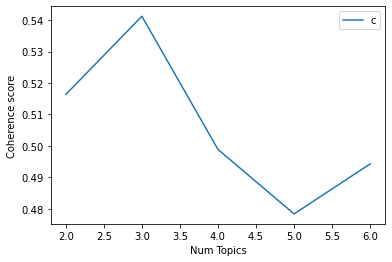

Num Topics = 2  has Coherence Value of 0.516352
Num Topics = 3  has Coherence Value of 0.541248
Num Topics = 4  has Coherence Value of 0.498875
Num Topics = 5  has Coherence Value of 0.478353
Num Topics = 6  has Coherence Value of 0.494269
Topic: 0 Word: 0.029*"tbs" + 0.024*"masukan" + 0.023*"cpo_pk" + 0.022*"titip_olah" + 0.017*"cpo" + 0.017*"olah" + 0.015*"titip" + 0.015*"harga_jual" + 0.014*"dikreditkan" + 0.012*"pk"
Topic: 1 Word: 0.023*"pembanding" + 0.017*"biaya" + 0.012*"debtor_biaya" + 0.012*"electronics_information" + 0.010*"operating_margin" + 0.009*"electronics" + 0.008*"margin" + 0.008*"display_devices" + 0.008*"debtor" + 0.007*"peredaran"
Topic: 2 Word: 0.018*"penerima_diluar" + 0.012*"klien_mencari" + 0.012*"diterbitkan_catatan" + 0.012*"vertikal" + 0.009*"penggantian_dibayarkan" + 0.009*"vat" + 0.009*"berkas_dipungut" + 0.009*"berwujud_istilah" + 0.009*"khusus_mengatur" + 0.009*"penilaian_objek"
PreparedData(topic_coordinates=              x         y  topics  cluster   

In [81]:
ppn_court_preprocessed_texts, ppn_court_text_list, ppn_court_doc_term_matrix, ppn_court_dictionary, ppn_court_model = topic_modelling(text_df=df_ppn, column_name='court_statement', label='PPN_court_statement_bow3',no_below=2,no_above=0.4, limit=7, coherence_method='c_v')

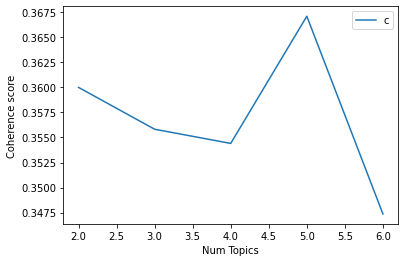

Num Topics = 2  has Coherence Value of 0.359998
Num Topics = 3  has Coherence Value of 0.355822
Num Topics = 4  has Coherence Value of 0.354406
Num Topics = 5  has Coherence Value of 0.367104
Num Topics = 6  has Coherence Value of 0.347367
Topic: 0 Word: 0.048*"pembayaran" + 0.037*"pemanfaatan" + 0.037*"biaya" + 0.025*"memenuhi" + 0.019*"pelaksanaan" + 0.019*"objek" + 0.019*"kliennya" + 0.019*"mencarikan" + 0.019*"kiliennya" + 0.019*"mengorganisir"
Topic: 1 Word: 0.171*"mewah_mempertahankan" + 0.095*"penyerahan_nilainya" + 0.090*"mewah" + 0.090*"dipungut" + 0.090*"nilainya" + 0.086*"mempertahankan" + 0.086*"mewah_mempertahankan_penyerahan_nilainya" + 0.005*"jenis" + 0.005*"objek" + 0.001*"ditolak"
Topic: 2 Word: 0.032*"masukan" + 0.030*"tbs" + 0.027*"cpo_pk" + 0.027*"unit_kebun" + 0.026*"bersifat_strategis" + 0.026*"dibebaskan" + 0.022*"menghasilkan" + 0.021*"unit_pabrik" + 0.018*"bahan" + 0.018*"unit"
Topic: 3 Word: 0.080*"pembelian" + 0.061*"harga" + 0.027*"peredaran" + 0.025*"peneli

In [83]:
ppn_government_preprocessed_texts, ppn_government_text_list, ppn_government_doc_term_matrix, ppn_government_dictionary, ppn_government_model = topic_modelling(text_df=df_ppn, column_name='government_statement', label='PPN_government_statement_bow3',no_below=2,no_above=0.4, limit=7, coherence_method='c_v')

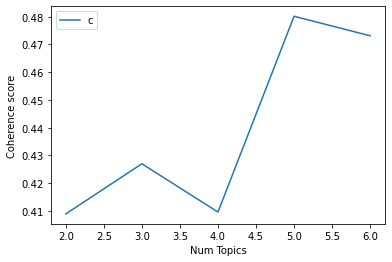

Num Topics = 2  has Coherence Value of 0.408887
Num Topics = 3  has Coherence Value of 0.426977
Num Topics = 4  has Coherence Value of 0.409558
Num Topics = 5  has Coherence Value of 0.480189
Num Topics = 6  has Coherence Value of 0.473134
Topic: 0 Word: 0.109*"barang" + 0.038*"pembeli" + 0.028*"masukan" + 0.020*"pemanfaatan" + 0.020*"pk" + 0.017*"quo" + 0.017*"pembayaran" + 0.017*"oil_cpo" + 0.017*"cpo" + 0.013*"kredit"
Topic: 1 Word: 0.036*"olah" + 0.036*"cpo" + 0.036*"distributor" + 0.036*"tbs" + 0.023*"setuju" + 0.023*"titip" + 0.023*"titip_olah" + 0.023*"masukan" + 0.019*"palm" + 0.019*"oil_cpo"
Topic: 2 Word: 0.063*"biaya" + 0.042*"pembanding" + 0.039*"tax" + 0.021*"ekspor" + 0.021*"konsisten" + 0.021*"penggantian" + 0.021*"electronics" + 0.021*"electronics_information" + 0.021*"information" + 0.021*"technology"
Topic: 3 Word: 0.054*"masukan" + 0.035*"nilainya_dipungut" + 0.034*"pembelian" + 0.034*"kelapa_sawit" + 0.032*"barang" + 0.026*"dikreditkan" + 0.023*"penjualan" + 0.021*"

In [80]:
ppn_taxpayer_preprocessed_texts, ppn_taxpayer_text_list, ppn_taxpayer_doc_term_matrix, ppn_taxpayer_dictionary, ppn_taxpayer_model = topic_modelling(text_df=df_ppn, column_name='txpayer_statement', label='PPN_taxpayer_statement_bow3', no_below=2, no_above=0.4, limit=7, coherence_method='c_v')

In [77]:
df_ppn['government_statement_bow'] = ppn_government_doc_term_matrix
df_ppn['taxpayer_statement_bow'] = ppn_taxpayer_doc_term_matrix
df_ppn['court_statement_bow'] = ppn_court_doc_term_matrix
df_ppn.head(66)

,Nomor Putusan,Jenis Pajak,Tahun Pajak,DV_Menang,case_circumstances,government_statement,taxpayer_statement,court_statement,court_considerants,case_contents,case_main_contents,txpayer_statement,government_statement_preprocessed,taxpayer_statement_preprocessed,court_statement_preprocessed,government_statement_bow,taxpayer_statement_bow,court_statement_bow
0,Put.072196.16.pdf,PPN dan PPnBM,2007,0,bahwa nilai sengketa dalam sengketa banding in...,bahwa terbanding melakukan koreksi atas transa...,bahwa bukti yang pemohon banding sampaikan jel...,menurut majelis : bahwa yang menjadi sengketa ...,bahwa dalam sengketa banding ini tidak terdapa...,bahwa nilai sengketa dalam sengketa banding in...,bahwa terbanding melakukan koreksi atas transa...,bahwa nilai sengketa dalam sengketa banding in...,nusantara inc nusantara inc informasi pasar gh...,barang pemanfaatan disetujui nusantara inc ent...,pemanfaatan disetujui penyerahan informasi pas...,"[(0, 1), (1, 1), (2, 1)]","[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1...","[(0, 4), (1, 9), (2, 1), (3, 2), (4, 2), (5, 5..."
5,Put.101125.16.pdf,PPN dan PPnBM,2012,0,bahwa nilai sengketa terbukti dalam sengketa b...,bahwa koreksi terbanding telah sesuai dengan k...,bahwa pemohon banding tidak setuju dengan alas...,menurut majelis : bahwa berdasarkan pemeriksaa...,"bahwa berdasarkan uraian tersebut di atas, rek...",bahwa nilai sengketa terbukti dalam sengketa b...,bahwa koreksi terbanding telah sesuai dengan k...,bahwa nilai sengketa terbukti dalam sengketa b...,kompeten dipertahankan ditolak,masukan disetujui setuju mengabaikan fakta pen...,berkas masukan disetujui keagenan dibiayakan g...,"[(3, 1), (4, 1), (5, 1)]","[(9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (...","[(1, 1), (2, 1), (7, 1), (10, 8), (12, 1), (16..."
6,Put.101126.16.pdf,PPN dan PPnBM,2012,0,bahwa nilai sengketa terbukti dalam sengketa b...,bahwa koreksi pemeriksa telah sesuai dengan ke...,bahwa pemohon banding tidak setuju dengan alas...,menurut majelis : bahwa berdasarkan pemeriksaa...,"bahwa berdasarkan uraian tersebut di atas, rek...",bahwa nilai sengketa terbukti dalam sengketa b...,bahwa koreksi pemeriksa telah sesuai dengan ke...,bahwa nilai sengketa terbukti dalam sengketa b...,kompeten dipertahankan ditolak,masukan disetujui setuju mengabaikan fakta pen...,berkas masukan disetujui keagenan dibiayakan g...,"[(3, 1), (4, 1), (5, 1)]","[(9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (...","[(1, 1), (2, 1), (7, 1), (10, 8), (12, 1), (16..."
7,Put.101736.16.pdf,PPN dan PPnBM,2011,0,koreksi pajak masukan masa pajak november 2011...,bahwa berdasarkan lhp dan kkp dijelaskan bahwa...,bahwa pemohon banding tidak setuju dengan kore...,menurut majelis : bahwa yang menjadi sengketa ...,bahwa atas hasil pemeriksaan dalam persidangan...,koreksi pajak masukan masa pajak november 2011...,bahwa berdasarkan lhp dan kkp dijelaskan bahwa...,koreksi pajak masukan masa pajak november 2011...,kkp masukan pembelian tanah dikoreksi memenuhi...,masukan disetujui setuju bayar pembelian tanah...,masukan dikreditkan disetujui masukan pembelia...,"[(0, 3), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1...","[(2, 2), (3, 1), (7, 1), (13, 7), (17, 1), (18...","[(6, 1), (16, 4), (21, 1), (23, 1), (25, 1), (..."
8,Put.104707.16.pdf,PPN dan PPnBM,2011,0,bahwa yang menjadi pokok sengketa dalam sengke...,bahwa terbanding keberatan menolak keberatan w...,bahwa pemohon banding tidak setuju terhadap al...,menurut majelis : bahwa berdasarkan pemeriksaa...,bahwa dalam sengketa banding ini tidak terdapa...,bahwa yang menjadi pokok sengketa dalam sengke...,bahwa terbanding keberatan menolak keberatan w...,bahwa yang menjadi pokok sengketa dalam sengke...,mempertahankan masukan pemanfaatan bkp berwuju...,masukan barang disetujui setuju tertuang mengi...,berkas objek masukan pemanfaatan jkp bkp berwu...,"[(23, 1), (38, 1), (39, 1), (40, 1), (41, 1), ...","[(0, 1), (4, 1), (13, 1), (17, 1), (36, 1), (3...","[(3, 1), (7, 1), (10, 8), (17, 2), (19, 4), (2..."
...,...,...,...,.

In [84]:
def generate_topic_probability(text_df, column_name, model):
    topic_assignment = []
    topic_detail_probability = []
    for i in range(len(text_df)):
        topic_predicted = model.get_document_topics(text_df.iloc[i][column_name])
        topic_assignment.append(topic_predicted[0][0])
        topic_predicted_detail = model.get_document_topics(text_df.iloc[i][column_name],
                                      minimum_probability=0.0)
        topic_detail_probability.append(topic_predicted_detail)
    col_name_assignment = column_name+'_assigned_topic'
    text_df[col_name_assignment] = topic_assignment
    for j in range(len(model.show_topics(num_words=30))):
        new_col = column_name+'_prob_topic_'+str(j)
        prob_topic = []
        for k in range(len(text_df)):
            prob_topic.append(topic_detail_probability[k][j][1])
        text_df[new_col] = prob_topic
    return text_df

In [85]:
final_dataset_pph_badan = df_pph_badan.copy()
final_dataset_pph_badan = generate_topic_probability(final_dataset_pph_badan,'taxpayer_statement_bow',pph_taxpayer_model)
final_dataset_pph_badan = generate_topic_probability(final_dataset_pph_badan,'government_statement_bow',pph_government_model)
final_dataset_pph_badan = generate_topic_probability(final_dataset_pph_badan,'court_statement_bow',pph_court_model)
final_dataset_pph_badan.head(18)

,Nomor Putusan,Jenis Pajak,Tahun Pajak,DV_Menang,case_circumstances,government_statement,taxpayer_statement,court_statement,court_considerants,case_contents,...,taxpayer_statement_bow_prob_topic_5,taxpayer_statement_bow_prob_topic_6,government_statement_bow_assigned_topic,government_statement_bow_prob_topic_0,government_statement_bow_prob_topic_1,government_statement_bow_prob_topic_2,court_statement_bow_assigned_topic,court_statement_bow_prob_topic_0,court_statement_bow_prob_topic_1,court_statement_bow_prob_topic_2
1,Put.086980.15.pdf,PPh Badan,2011,0,bahwa nilai sengketa terbukti dalam sengketa b...,a. koreksi atas biaya royalti sebesar rp. 52.0...,menurut pemohon banding koreksi atas pembayara...,menurut majelis : bahwa yang menjadi sengketa ...,bahwa dalam sengketa banding ini tidak terdapa...,bahwa nilai sengketa terbukti dalam sengketa b...,...,0.892726,0.017858,0,0.939430,0.029636,0.030934,0,0.094579,0.001680,0.903741
2,Put.087101.15.pdf,PPh Badan,2012,0,bahwa nilai sengketa terbukti dalam sengketa b...,bahwa menurut terbanding koreksi harga pokok p...,bahwa metode comparable uncontrolled price (cu...,menurut majelis : bahwa majelis berpendapat sk...,bahwa dalam hal dilakukan analisa berdasar com...,bahwa nilai sengketa terbukti dalam sengketa b...,...,0.015918,0.015874,0,0.777609,0.111162,0.111229,0,0.045524,0.896758,0.057718
3,Put.098444.15.pdf,PPh Badan,2012,1,bahwa nilai sengketa terbukti dalam banding in...,bahwa dasar dilakukan koreksi technical assist...,pemohon banding mengemukakan mengenai jasa yan...,menurut majelis : bahwa yang menjadi sengketa ...,"atas hasil pemeriksaan dalam persidangan, maje...",bahwa nilai sengketa terbukti dalam banding in...,...,0.001905,0.001905,0,0.814736,0.083563,0.101702,0,0.998579,0.000709,0.000712
4,Put.098538.15.pdf,PPh Badan,2012,0,bahwa nilai yang menjadi pokok sengketa dalam ...,bahwa oleh terbanding dalam sub dan penjelasan...,bahwa pemohon banding menambahkan penjelasanny...,menurut majelis : bahwa yang menjadi sengketa ...,bahwa atas hasil pemeriksaan dalam persidangan...,bahwa nilai yang menjadi pokok sengketa dalam ...,...,0.003248,0.003247,0,0.915648,0.045744,0.038608,0,0.997729,0.001116,0.001154
12,Put.106741.15.pdf,PPh Badan,2013,0,bahwa nilai sengketa terbukti dalam sengketa b...,bahwa pada saat pembahasan akhir hasil pemerik...,"bahwa koreksi positif sejumlah usd12,914,809 m...","menurut majelis : bahwa menurut terbanding, te...",bahwa dalam sengketa banding ini terdapat seng...,bahwa nilai sengketa terbukti dalam sengketa b...,...,0.000563,0.000563,1,0.002377,0.995373,0.002250,2,0.001325,0.001220,0.997455
15,Put.109167.15.pdf,PPh Badan,2013,0,bahwa nilai sengketa terbukti dalam sengketa b...,.109167.15/2013/pp/m.xviiib tahun 2018 jenis p...,67.15/2013/pp/m.xviiib tahun 2018 jenis pajak ...,menurut majelis : bahwa dasar hukum yang digun...,bahwa dalam sengketa banding ini tidak terdapa...,bahwa nilai sengketa terbukti dalam sengketa b...,...,0.000187,0.000187,0,0.997247,0.001426,0.001326,0,0.990828,0.004427,0.004745
16,Put.79846.pdf,PPh Badan,2010,0,bahwa nilai sengketa terbukti dalam sengketa b...,bahwa terdapat transaksi hubungan istimewa ata...,"bahwa dalam proses pemeriksaan, terbanding mel...",menurut majelis : bahwa koreksi dilakukan terb...,bahwa dalam sengketa banding ini tidak terdapa...,bahwa nilai sengketa terbukti dalam sengketa b...,...,0.003327,0.003325,0,0.174505,0.184784,0.640712,0,0.999236,0.000380,0.000384
20,Put.80425.pdf,PPh Badan,2011,1,bahwa dalam sengketa banding ini tidak terdapa...,bahwa terbanding tidak setuju dengan searching...,bahwa berdasarkan transfer pricing documentati...,menurut majelis : bahwa menurut terbanding kor...,bahwa oleh karena hasil pemeriksaan dalam pers...,bahwa dalam sengketa banding ini tidak terdapa...,...,0.968248,0.005293,0,0.211177,0.043112,0.745711,1,0.000636,0.998738,0.000626
25,Put.80603.pdf,PPh Badan,2011,0,bahwa yang menjadi pokok sengketa dalam sengke...,"bahwa dalam melakukan koreksi, terbanding meng...",bah

In [86]:
final_dataset_ppn = df_ppn.copy()
final_dataset_ppn = generate_topic_probability(final_dataset_ppn,'taxpayer_statement_bow',ppn_taxpayer_model)
final_dataset_ppn = generate_topic_probability(final_dataset_ppn,'government_statement_bow',ppn_government_model)
final_dataset_ppn = generate_topic_probability(final_dataset_ppn,'court_statement_bow',ppn_court_model)
final_dataset_ppn.head(18)

,Nomor Putusan,Jenis Pajak,Tahun Pajak,DV_Menang,case_circumstances,government_statement,taxpayer_statement,court_statement,court_considerants,case_contents,...,government_statement_bow_assigned_topic,government_statement_bow_prob_topic_0,government_statement_bow_prob_topic_1,government_statement_bow_prob_topic_2,government_statement_bow_prob_topic_3,government_statement_bow_prob_topic_4,court_statement_bow_assigned_topic,court_statement_bow_prob_topic_0,court_statement_bow_prob_topic_1,court_statement_bow_prob_topic_2
0,Put.072196.16.pdf,PPN dan PPnBM,2007,0,bahwa nilai sengketa dalam sengketa banding in...,bahwa terbanding melakukan koreksi atas transa...,bahwa bukti yang pemohon banding sampaikan jel...,menurut majelis : bahwa yang menjadi sengketa ...,bahwa dalam sengketa banding ini tidak terdapa...,bahwa nilai sengketa dalam sengketa banding in...,...,0,0.798866,0.050097,0.050001,0.050836,0.050200,0,0.588846,0.409995,0.001159
5,Put.101125.16.pdf,PPN dan PPnBM,2012,0,bahwa nilai sengketa terbukti dalam sengketa b...,bahwa koreksi terbanding telah sesuai dengan k...,bahwa pemohon banding tidak setuju dengan alas...,menurut majelis : bahwa berdasarkan pemeriksaa...,"bahwa berdasarkan uraian tersebut di atas, rek...",bahwa nilai sengketa terbukti dalam sengketa b...,...,0,0.050010,0.050007,0.050039,0.799938,0.050007,2,0.001000,0.000969,0.998031
6,Put.101126.16.pdf,PPN dan PPnBM,2012,0,bahwa nilai sengketa terbukti dalam sengketa b...,bahwa koreksi pemeriksa telah sesuai dengan ke...,bahwa pemohon banding tidak setuju dengan alas...,menurut majelis : bahwa berdasarkan pemeriksaa...,"bahwa berdasarkan uraian tersebut di atas, rek...",bahwa nilai sengketa terbukti dalam sengketa b...,...,0,0.050010,0.050007,0.050039,0.799938,0.050007,2,0.001000,0.000969,0.998031
7,Put.101736.16.pdf,PPN dan PPnBM,2011,0,koreksi pajak masukan masa pajak november 2011...,bahwa berdasarkan lhp dan kkp dijelaskan bahwa...,bahwa pemohon banding tidak setuju dengan kore...,menurut majelis : bahwa yang menjadi sengketa ...,bahwa atas hasil pemeriksaan dalam persidangan...,koreksi pajak masukan masa pajak november 2011...,...,0,0.205988,0.003847,0.003939,0.388468,0.397757,0,0.822833,0.175909,0.001258
8,Put.104707.16.pdf,PPN dan PPnBM,2011,0,bahwa yang menjadi pokok sengketa dalam sengke...,bahwa terbanding keberatan menolak keberatan w...,bahwa pemohon banding tidak setuju terhadap al...,menurut majelis : bahwa berdasarkan pemeriksaa...,bahwa dalam sengketa banding ini tidak terdapa...,bahwa yang menjadi pokok sengketa dalam sengke...,...,0,0.029002,0.029533,0.028653,0.028603,0.884210,2,0.001230,0.001167,0.997603
9,Put.104708.16.pdf,PPN dan PPnBM,2011,0,bahwa yang menjadi pokok sengketa dalam sengke...,bahwa terbanding menolak keberatan pemohon ban...,bahwa pemohon banding tidak setuju terhadap al...,menurut majelis : bahwa berdasarkan pemeriksaa...,bahwa dalam sengketa banding ini tidak terdapa...,bahwa yang menjadi pokok sengketa dalam sengke...,...,0,0.029002,0.029542,0.028653,0.028603,0.884200,2,0.001231,0.001167,0.997602
10,Put.104709.16.pdf,PPN dan PPnBM,2011,0,bahwa yang menjadi pokok sengketa dalam sengke...,"bahwa menurut terbanding, koreksi pajak masuka...",bahwa pemohon banding tidak setuju terhadap al...,menurut majelis : bahwa berdasarkan pemeriksaa...,bahwa dalam sengketa banding ini tidak terdapa...,bahwa yang menjadi pokok sengketa dalam sengke...,...,0,0.020194,0.020402,0.020038,0.020335,0.919030,2,0.001231,0.001167,0.997603
11,Put.104710.16.pdf,PPN dan PPnBM,2011,0,bahwa yang menjadi pokok sengketa dalam sengke...,bahwa terbanding keberatan menolak keberatan w...,bahwa pemohon banding tidak setuju terhadap al...,menurut majelis : bahwa berdasarkan pemeriksaa...,bahwa dalam sengketa banding ini tidak terdapa...,bahwa yang menjadi pokok sengketa dalam sengke...,...,0,0.029002,0.029545,0.028653,0.028603,0.884197,2,0.001231,0.001167,0.997603
13,Put.107017.16.pdf,PPN dan PPnBM,2013,0,"koreksi sebesar rp155.021.128,00, dengan pokok...",bahwa

In [87]:
final_dataset_pph_badan.to_csv('final_dataset_pph_badan.csv',index=False)

In [88]:
final_dataset_ppn.to_csv('final_dataset_ppn.csv',index=False)

In [89]:
x = final_dataset_pph_badan.groupby(['DV_Menang']).count()
x

,Nomor Putusan,Jenis Pajak,Tahun Pajak,case_circumstances,government_statement,taxpayer_statement,court_statement,court_considerants,case_contents,case_main_contents,...,taxpayer_statement_bow_prob_topic_5,taxpayer_statement_bow_prob_topic_6,government_statement_bow_assigned_topic,government_statement_bow_prob_topic_0,government_statement_bow_prob_topic_1,government_statement_bow_prob_topic_2,court_statement_bow_assigned_topic,court_statement_bow_prob_topic_0,court_statement_bow_prob_topic_1,court_statement_bow_prob_topic_2
DV_Menang,,,,,,,,,,,,,,,,,,,,,
0,12,12,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12
1,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6


In [90]:
x = final_dataset_ppn.groupby(['DV_Menang']).count()
x

,Nomor Putusan,Jenis Pajak,Tahun Pajak,case_circumstances,government_statement,taxpayer_statement,court_statement,court_considerants,case_contents,case_main_contents,...,government_statement_bow_assigned_topic,government_statement_bow_prob_topic_0,government_statement_bow_prob_topic_1,government_statement_bow_prob_topic_2,government_statement_bow_prob_topic_3,government_statement_bow_prob_topic_4,court_statement_bow_assigned_topic,court_statement_bow_prob_topic_0,court_statement_bow_prob_topic_1,court_statement_bow_prob_topic_2
DV_Menang,,,,,,,,,,,,,,,,,,,,,
0,55,55,55,55,55,55,55,55,55,55,...,55,55,55,55,55,55,55,55,55,55
1,11,11,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11


## 1. PPh Topic

# Government Statement

In [91]:
pph_government_model.show_topics(num_topics=20, num_words=30, log=False, formatted=True)

[(0,
  '0.181*"penjualan" + 0.120*"biaya" + 0.047*"harga" + 0.039*"manajemen" + 0.030*"sales" + 0.030*"pembayaran" + 0.028*"dibebankan" + 0.027*"manfaat" + 0.021*"tertulis" + 0.018*"kredit" + 0.018*"pembebanan" + 0.015*"saham" + 0.015*"neto" + 0.013*"argumentasi" + 0.013*"management" + 0.013*"informasi" + 0.013*"eksistensi" + 0.013*"royalti" + 0.013*"pk" + 0.013*"lahan" + 0.010*"lazim" + 0.010*"dibayar" + 0.010*"dividen" + 0.010*"dibayarkan" + 0.010*"ketetapan" + 0.010*"bayar" + 0.010*"rugi" + 0.010*"fee" + 0.007*"analisa" + 0.007*"pengujian"'),
 (1,
  '0.181*"bunga" + 0.138*"biaya" + 0.045*"perjanjian" + 0.045*"kredit" + 0.040*"dibebankan" + 0.040*"pk" + 0.029*"piutang" + 0.024*"diperoleh" + 0.024*"uang" + 0.024*"mata" + 0.023*"menagih" + 0.023*"memelihara" + 0.018*"informasi" + 0.013*"pengujian" + 0.013*"pembebanan" + 0.013*"kondisi" + 0.013*"singapura" + 0.013*"total" + 0.013*"rupiah" + 0.013*"rincian" + 0.013*"keuntungan" + 0.013*"dibayarkan" + 0.013*"saham" + 0.013*"pendukung" + 0

# Taxpayer Statement

In [92]:
pph_taxpayer_model.show_topics(num_topics=20, num_words=30, log=False, formatted=True)

[(0,
  '0.024*"biaya" + 0.024*"know" + 0.016*"kuartil" + 0.016*"rentang" + 0.016*"komponen" + 0.016*"aktiva" + 0.016*"rugi" + 0.016*"penerapan" + 0.016*"penjualan" + 0.009*"fee" + 0.009*"pengujian" + 0.009*"memperhitungkan" + 0.009*"dibandingkan" + 0.009*"tertimbang" + 0.009*"sewa" + 0.009*"scrap" + 0.009*"penyesuaianpenyesuaian" + 0.009*"pendapatan" + 0.009*"kurs" + 0.009*"expenses" + 0.009*"dicatat" + 0.009*"ncpm" + 0.009*"sependapat" + 0.009*"prosedur" + 0.009*"principle" + 0.009*"komersial" + 0.009*"enterprises" + 0.009*"pembanding" + 0.009*"analisa" + 0.009*"pemberian"'),
 (1,
  '0.055*"bunga" + 0.052*"pif" + 0.035*"pinjaman" + 0.021*"saham" + 0.018*"bank" + 0.015*"biaya" + 0.015*"tagihan" + 0.012*"putusan" + 0.012*"perjanjian" + 0.012*"agreement" + 0.012*"loan" + 0.012*"pkpu" + 0.009*"fee" + 0.009*"hak" + 0.009*"penyaluran" + 0.009*"status" + 0.009*"anggaran" + 0.009*"annual" + 0.009*"kewajiban" + 0.009*"utang" + 0.009*"dilaporkan" + 0.009*"tppi" + 0.009*"memperoleh" + 0.009*"fak

# Court Statement

In [93]:
pph_court_model.show_topics(num_topics=20, num_words=30, log=False, formatted=True)

[(0,
  '0.060*"royalti" + 0.045*"pembayaran_royalti" + 0.018*"merek_dagang" + 0.016*"manfaat_ekonomis" + 0.015*"biaya_royalti" + 0.009*"technical_assistance" + 0.009*"merek" + 0.008*"cup" + 0.008*"manfaat" + 0.008*"dagang" + 0.007*"lisensi" + 0.007*"intangible" + 0.007*"trademark" + 0.007*"barang" + 0.007*"aktiva" + 0.007*"produksi" + 0.007*"paten" + 0.006*"property" + 0.006*"perbandingan_harga" + 0.006*"cost_plus" + 0.006*"eksistensi" + 0.006*"dividen" + 0.006*"assistance" + 0.006*"ahli" + 0.006*"trade" + 0.005*"fee" + 0.005*"berwujud" + 0.005*"technical" + 0.005*"transactional_margin" + 0.005*"sales"'),
 (1,
  '0.036*"operating_margin" + 0.016*"profit_indicator" + 0.016*"operasi" + 0.014*"analisa_kesebandingan" + 0.014*"profit" + 0.013*"transactional_margin" + 0.013*"tested_party" + 0.012*"technology" + 0.011*"analisa" + 0.010*"expenses" + 0.010*"komponen" + 0.010*"rentang" + 0.008*"information" + 0.008*"perbedaan" + 0.008*"cost_plus" + 0.008*"peredaran" + 0.008*"party" + 0.007*"indi

## 2. PPN Topic

# Government Statement

In [94]:
ppn_government_model.show_topics(num_topics=20, num_words=30, log=False, formatted=True)

[(0,
  '0.048*"pembayaran" + 0.037*"pemanfaatan" + 0.037*"biaya" + 0.025*"memenuhi" + 0.019*"pelaksanaan" + 0.019*"objek" + 0.019*"kliennya" + 0.019*"mengorganisir" + 0.019*"kiliennya" + 0.019*"mencarikan" + 0.019*"pembahasan" + 0.019*"mewah" + 0.018*"dibayar" + 0.015*"berbeda" + 0.015*"informasi" + 0.013*"pemberian" + 0.013*"kontrak" + 0.013*"orang" + 0.013*"alat" + 0.013*"mengatur" + 0.013*"minyak" + 0.013*"menerbitkan" + 0.013*"dijual" + 0.013*"risalah" + 0.013*"langsung" + 0.013*"audit" + 0.013*"bangunan" + 0.009*"membuktikan" + 0.008*"dilaporkan" + 0.007*"mengajukan"'),
 (1,
  '0.171*"mewah_mempertahankan" + 0.095*"penyerahan_nilainya" + 0.090*"mewah" + 0.090*"dipungut" + 0.090*"nilainya" + 0.086*"mempertahankan" + 0.086*"mewah_mempertahankan_penyerahan_nilainya" + 0.005*"jenis" + 0.005*"objek" + 0.001*"ditolak" + 0.001*"searching_criteria" + 0.001*"criteria" + 0.001*"searching" + 0.001*"kompeten" + 0.001*"berhubungan" + 0.001*"pasar" + 0.001*"setuju" + 0.001*"pelaksanaan" + 0.001

# Taxpayer Statement

In [97]:
ppn_taxpayer_model.show_topics(num_topics=20, num_words=30, log=False, formatted=True)

[(0,
  '0.109*"barang" + 0.038*"pembeli" + 0.028*"masukan" + 0.020*"pemanfaatan" + 0.020*"pk" + 0.017*"quo" + 0.017*"pembayaran" + 0.017*"oil_cpo" + 0.017*"cpo" + 0.013*"kredit" + 0.013*"dikenakan" + 0.013*"setuju" + 0.010*"analisis" + 0.010*"perkara" + 0.008*"pendukung" + 0.008*"usahanya" + 0.008*"penyerahannya_dibebaskan" + 0.008*"penyerahannya" + 0.008*"inti" + 0.008*"menghasilkan" + 0.008*"cpo_pk" + 0.008*"crude_palm_oil_cpo" + 0.008*"perolehan" + 0.008*"crude" + 0.008*"oil" + 0.008*"crude_palm" + 0.008*"dibebaskan" + 0.008*"sawit" + 0.008*"mengikuti" + 0.008*"ekspor"'),
 (1,
  '0.036*"olah" + 0.036*"cpo" + 0.036*"distributor" + 0.036*"tbs" + 0.023*"setuju" + 0.023*"titip" + 0.023*"titip_olah" + 0.023*"masukan" + 0.019*"palm" + 0.019*"oil_cpo" + 0.019*"pk" + 0.019*"diolah" + 0.019*"melandaskan" + 0.019*"bentuk" + 0.019*"koreksinya" + 0.019*"mengatur" + 0.019*"barang" + 0.014*"perkara" + 0.010*"crude_palm_oil_cpo" + 0.010*"oil" + 0.010*"crude" + 0.010*"crude_palm" + 0.010*"cpo_pk" +

# Court Statement

In [96]:
ppn_court_model.show_topics(num_topics=20, num_words=30, log=False, formatted=True)

[(0,
  '0.029*"tbs" + 0.024*"masukan" + 0.023*"cpo_pk" + 0.022*"titip_olah" + 0.017*"cpo" + 0.017*"olah" + 0.015*"titip" + 0.015*"harga_jual" + 0.014*"dikreditkan" + 0.012*"pk" + 0.010*"pengkreditan_masukan" + 0.009*"dibebaskan" + 0.009*"penyerahannya_dibebaskan" + 0.009*"tujuan_produktif" + 0.008*"pemakaian" + 0.008*"cpo_pko" + 0.008*"penyerahannya" + 0.008*"pemakaian_pemberian" + 0.007*"sawit" + 0.007*"pabrik" + 0.007*"biaya" + 0.007*"perolehan" + 0.007*"menghasilkan" + 0.007*"distributor" + 0.006*"palm" + 0.006*"perjanjian" + 0.006*"jual" + 0.006*"kebun" + 0.006*"dibayar_perolehan" + 0.006*"dihasilkan"'),
 (1,
  '0.023*"pembanding" + 0.017*"biaya" + 0.012*"debtor_biaya" + 0.012*"electronics_information" + 0.010*"operating_margin" + 0.009*"electronics" + 0.008*"margin" + 0.008*"display_devices" + 0.008*"debtor" + 0.007*"peredaran" + 0.007*"sebanding" + 0.007*"operating" + 0.007*"technology" + 0.007*"information" + 0.007*"crystal" + 0.006*"display" + 0.006*"devices" + 0.006*"electroni